In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
from scipy.stats import beta as sp_beta
from scipy.special import logit

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = 20, 15
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth'] = 2
import seaborn as sns

import sys
sys.path.insert(0, '../../..')
import assignment
import leximin_assignment
import matrix_gen
import kde_utils

from tqdm import tqdm

import warnings

# Distributions of normalized costs

In [2]:
df = pd.read_csv('../../../data/data.csv', index_col=0)
types = ['ES', 'TH', 'RRH', 'PREV']
df = df[df['Real'] != 2]
df = df.drop(labels='PSH', axis=1)

data = df[types].to_numpy().flatten()
kde = kde_utils.KDEHelper(np.log(data) - np.log(1 - data))

In [6]:
N = 30
N_INTVS = 5
N_EXPERIMENTS = 1000  # 10 and 500

CAPACITIES = np.ones((N_INTVS,), dtype=int) * (N // N_INTVS)

In [4]:
distributions = [
    np.random.uniform,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    np.random.beta,
    kde.sample_and_transform
]

dist_params = [
    (0, 1),
    (1, 6),
    (6, 1),
    (2, 5),
    (5, 2),
    (0.5, 0.5),
    (0.1, 0.1),
    (0.6, 0.1),
    (0.1, 0.6),
    (lambda x: 1 / (1 + np.exp(-x)), None)
]

matrix_generators = [
    matrix_gen.MatrixGenerator(dist, params, N, N_INTVS)
    for dist, params in zip(distributions, dist_params)
]

labels = [
    f'{dist.__name__}({params[0]}, {params[1]})'
    for dist, params in zip(distributions, dist_params)
]
labels[-1] = 'KDE'

labels

['uniform(0, 1)',
 'beta(1, 6)',
 'beta(6, 1)',
 'beta(2, 5)',
 'beta(5, 2)',
 'beta(0.5, 0.5)',
 'beta(0.1, 0.1)',
 'beta(0.6, 0.1)',
 'beta(0.1, 0.6)',
 'KDE']

In [12]:
cost_pop = [np.array([]) for _ in range(len(labels))]
increase_pop = [np.array([]) for _ in range(len(labels))]

for _ in tqdm(range(N_EXPERIMENTS)):
    for dist_id in range(len(labels)):
        (_, sorted_matrix), (__, sorted_increase_matrix) = matrix_generators[dist_id].get_increase_matrix_pair()
        
        cost_pop[dist_id] = np.concatenate([
            cost_pop[dist_id],
            sorted_matrix[:, -1].flatten()
        ])
        
        increase_pop[dist_id] = np.concatenate([
            increase_pop[dist_id],
            sorted_increase_matrix[:, -1].flatten()
        ])

100%|██████████| 1000/1000 [00:00<00:00, 1523.47it/s]


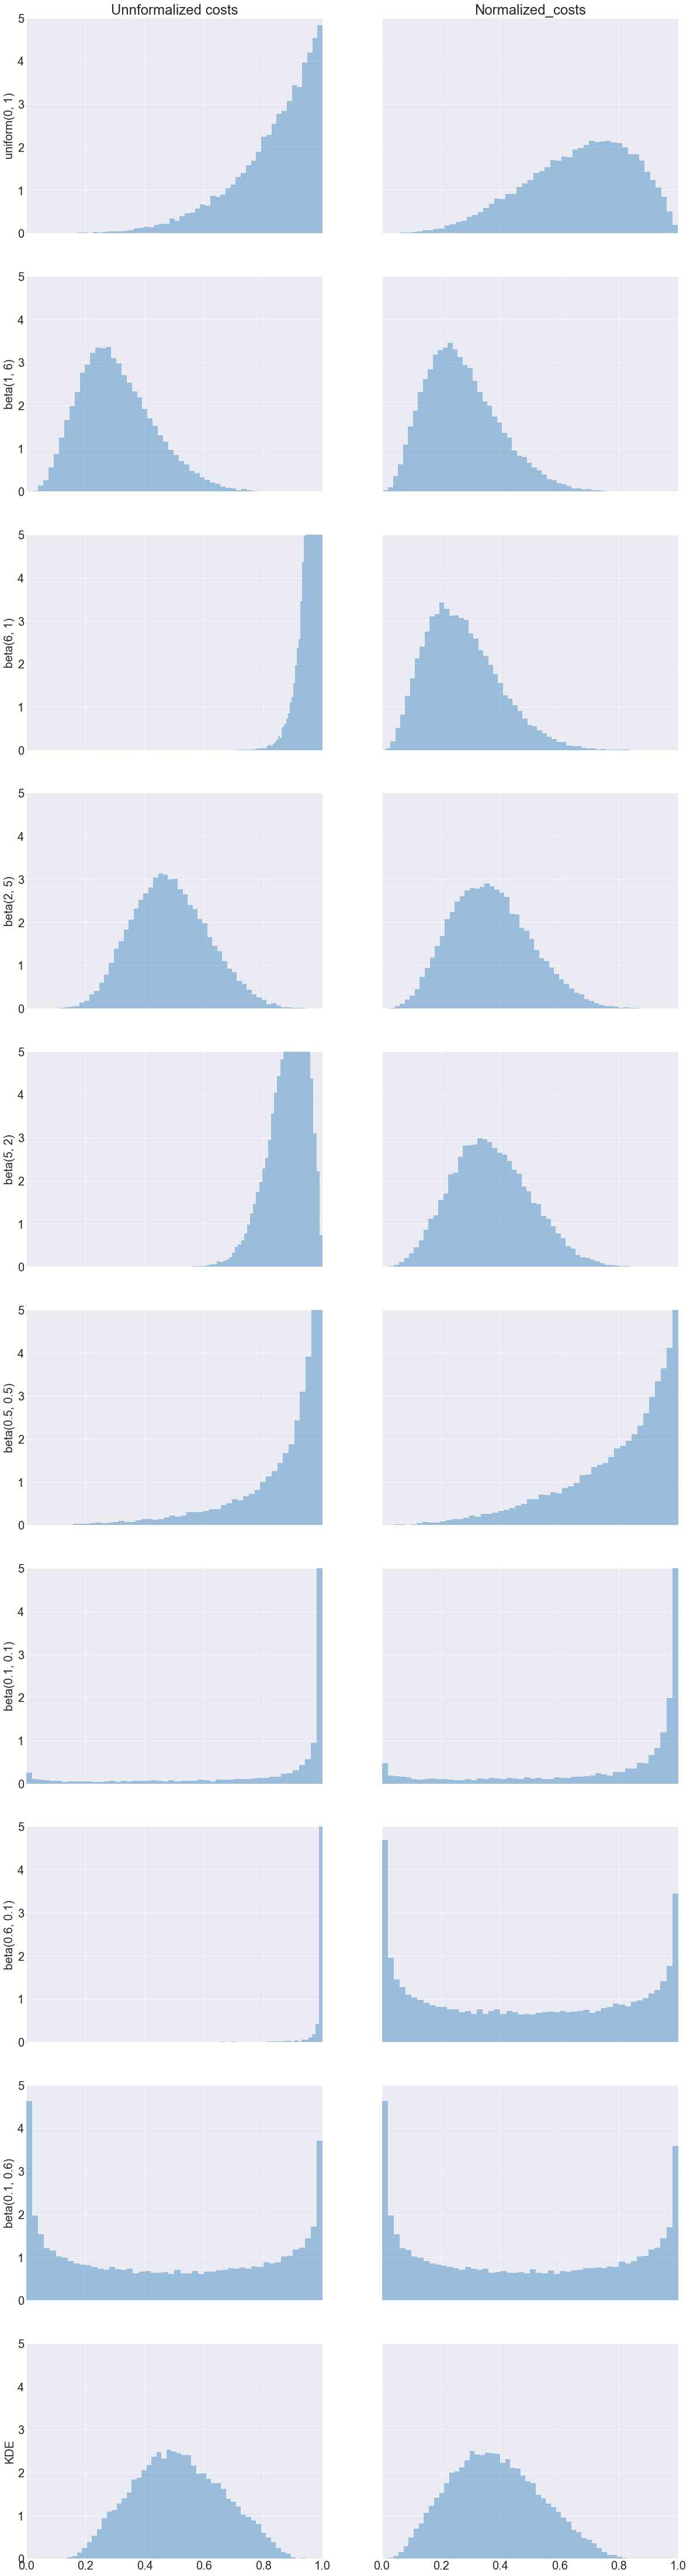

In [9]:
fig, ax = plt.subplots(len(labels), 2, figsize=(20, 8 * len(labels)), sharex=True, sharey=True)

xs = np.linspace(0, 1, 1000)

for dist_id in range(len(labels)):
    ax[dist_id][0].hist(cost_pop[dist_id], bins=50, alpha=0.4, density=True)
    ax[dist_id][1].hist(increase_pop[dist_id], bins=50, alpha=0.4, density=True)

    ax[dist_id][0].set_ylabel(labels[dist_id])
    ax[dist_id][0].set_ylim(0, 5)
    ax[dist_id][0].set_xlim(0, 1)
    
ax[0][0].set_title('Unnformalized costs')
ax[0][1].set_title('Normalized_costs')

plt.show()

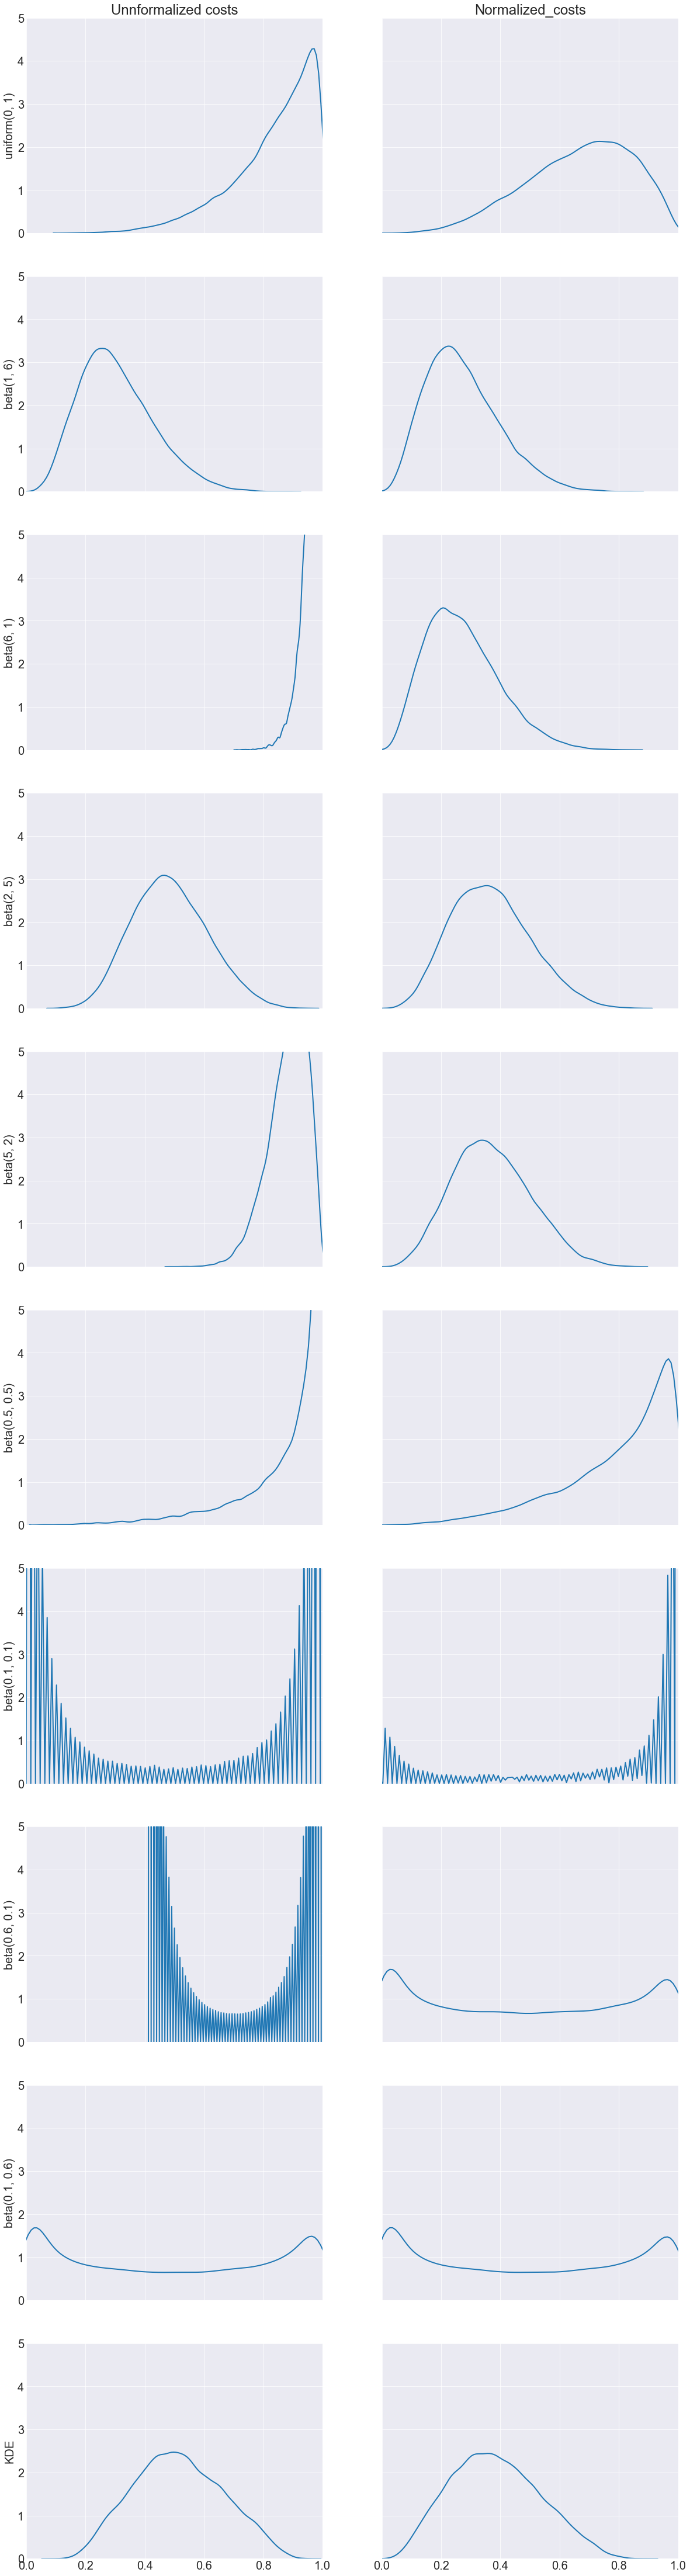

In [10]:
fig, ax = plt.subplots(len(labels), 2, figsize=(20, 8 * len(labels)), sharex=True, sharey=True)

xs = np.linspace(0, 1, 1000)

for dist_id in range(len(labels)):
    sns.kdeplot(cost_pop[dist_id], ax=ax[dist_id][0], bw='silverman')
    sns.kdeplot(increase_pop[dist_id], ax=ax[dist_id][1], bw='silverman')

    ax[dist_id][0].set_ylabel(labels[dist_id])
    ax[dist_id][0].set_ylim(0, 5)
    ax[dist_id][0].set_xlim(0, 1)
    
ax[0][0].set_title('Unnformalized costs')
ax[0][1].set_title('Normalized_costs')

plt.show()

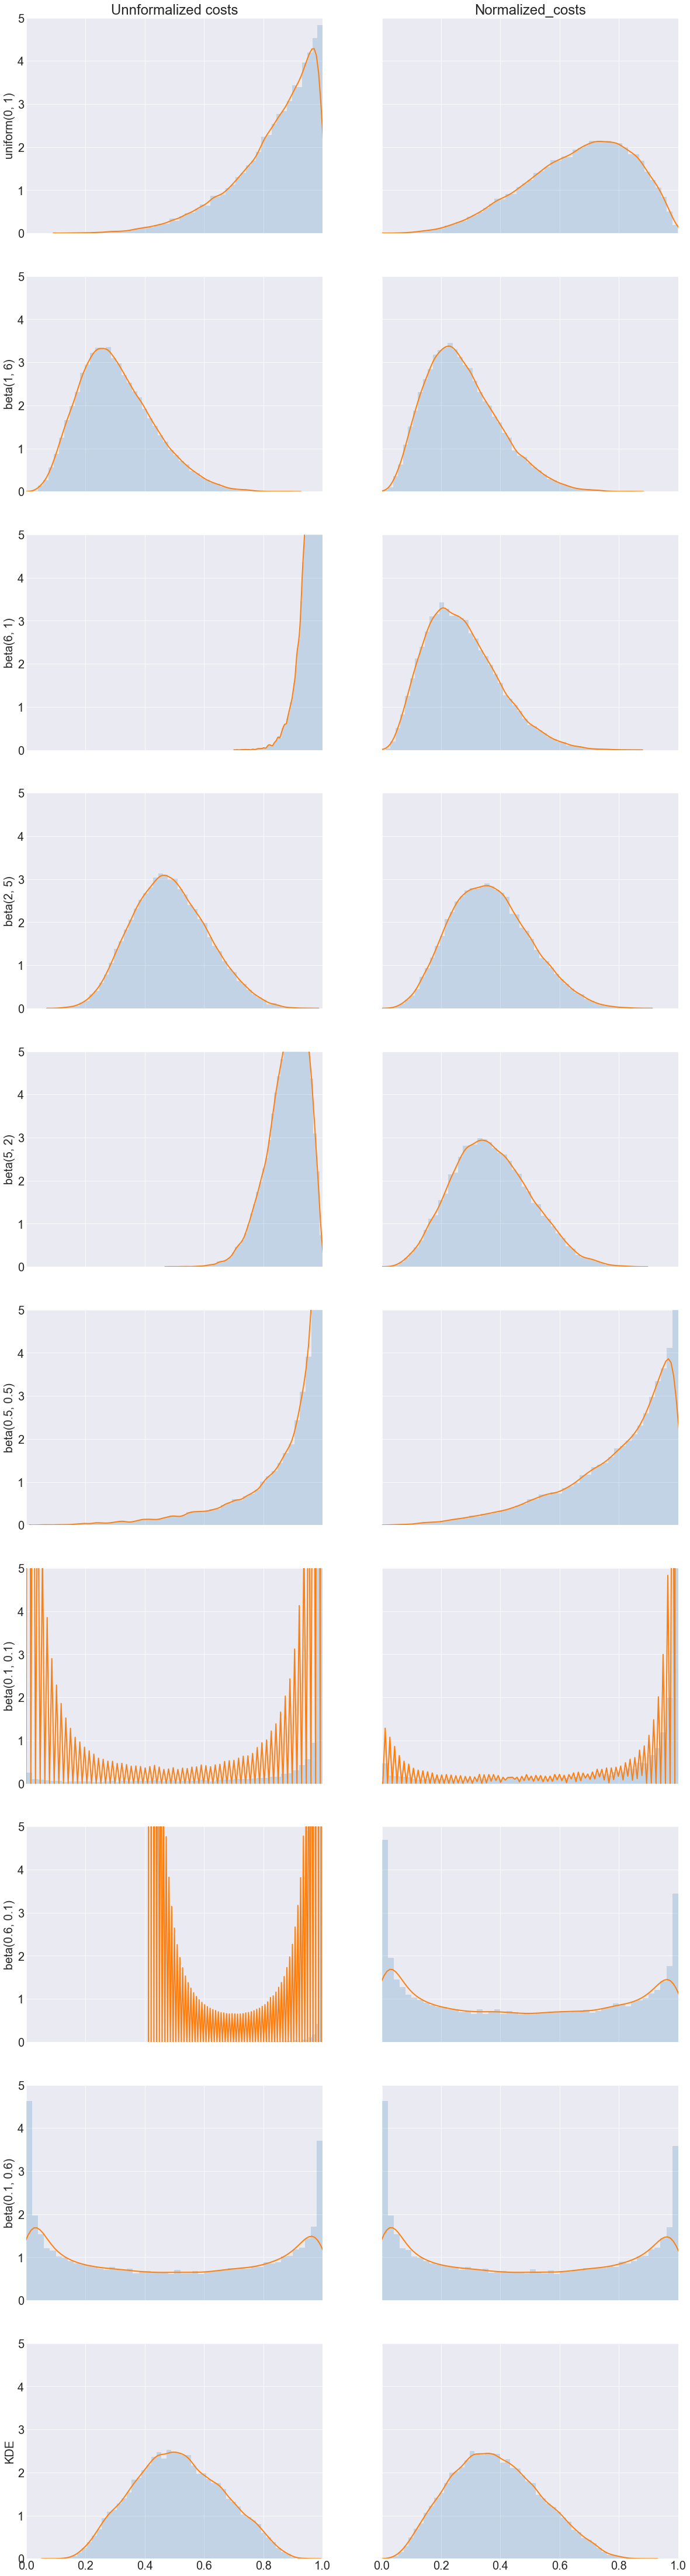

In [6]:
fig, ax = plt.subplots(len(labels), 2, figsize=(20, 8 * len(labels)), sharex=True, sharey=True)

xs = np.linspace(0, 1, 1000)

for dist_id in range(len(labels)):
    ax[dist_id][0].hist(cost_pop[dist_id], bins=50, alpha=0.2, density=True)
    ax[dist_id][1].hist(increase_pop[dist_id], bins=50, alpha=0.2, density=True)
    
    sns.kdeplot(cost_pop[dist_id], ax=ax[dist_id][0], bw='silverman')
    sns.kdeplot(increase_pop[dist_id], ax=ax[dist_id][1], bw='silverman')

    ax[dist_id][0].set_ylabel(labels[dist_id])
    ax[dist_id][0].set_ylim(0, 5)
    ax[dist_id][0].set_xlim(0, 1)
    
ax[0][0].set_title('Unnformalized costs')
ax[0][1].set_title('Normalized_costs')

plt.show()

# Bounded KDE

In [13]:
for dist_id in range(len(labels)):
    max_cost = cost_pop[dist_id][cost_pop[dist_id] < 1].max()
    min_cost = cost_pop[dist_id][cost_pop[dist_id] > 0].min()
    
    cost_pop[dist_id][cost_pop[dist_id] == 0] = min_cost
    cost_pop[dist_id][cost_pop[dist_id] == 1] = max_cost
    
    
    max_increase = increase_pop[dist_id][increase_pop[dist_id] < 1].max()
    min_increase = increase_pop[dist_id][increase_pop[dist_id] > 0].min()

    increase_pop[dist_id][increase_pop[dist_id] == 0] = min_increase
    increase_pop[dist_id][increase_pop[dist_id] == 1] = max_increase

In [14]:
cost_bandwidths = []
increase_bandwidths = []

for dist_id in range(len(labels)):
    temp_cost_pop = logit(cost_pop[dist_id])
    
    cost_bandwidths.append(
        0.9 
        * min(
            temp_cost_pop.std(),
            np.subtract(*np.percentile(temp_cost_pop, [75, 25])) / 1.34
        ) 
        * temp_cost_pop.size ** (-1 / 5)
    )
    
    temp_increase_pop = logit(increase_pop[dist_id])
    
    increase_bandwidths.append(
        0.9 
        * min(
            temp_increase_pop.std(),
            np.subtract(*np.percentile(temp_increase_pop, [75, 25])) / 1.34
        ) 
        * temp_increase_pop.size ** (-1 / 5)
    )
    
cost_bandwidths = np.array(cost_bandwidths)
increase_bandwidths = np.array(increase_bandwidths)

In [15]:
min_bandwidth = cost_bandwidths[cost_bandwidths > 0].min()
cost_bandwidths[cost_bandwidths == 0] = min_bandwidth

min_bandwidth = increase_bandwidths[increase_bandwidths > 0].min()
increase_bandwidths[increase_bandwidths == 0] = min_bandwidth

0
1
2
3
4
5
6
7
8
9


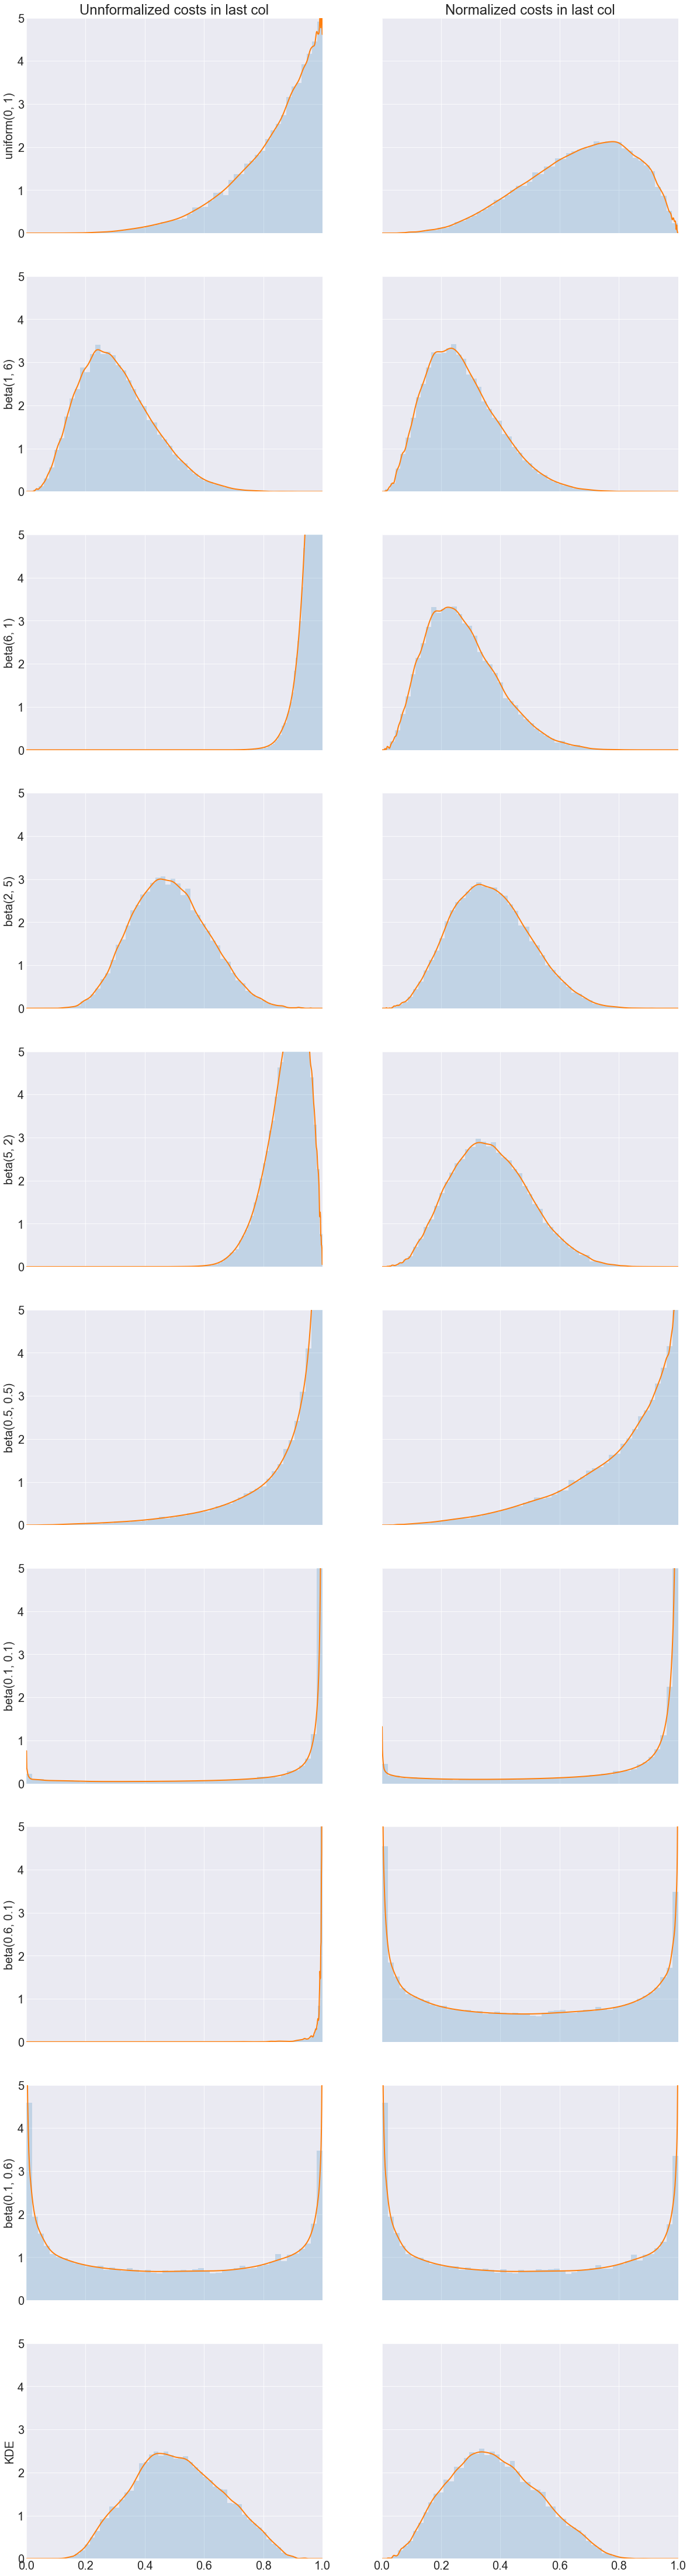

In [16]:
fig, ax = plt.subplots(len(labels), 2, figsize=(20, 8 * len(labels)), sharex=True, sharey=True)

xs = np.linspace(0, 1, 1002)[1: -1].reshape(-1, 1)

for dist_id in range(len(labels)):
    print(dist_id)
    
    ax[dist_id][0].hist(cost_pop[dist_id], bins=50, alpha=0.2, density=True)
    ax[dist_id][1].hist(increase_pop[dist_id], bins=50, alpha=0.2, density=True)
    
    kde = kde_utils.KDEHelper(cost_pop[dist_id], cost_bandwidths[dist_id])
    ax[dist_id][0].plot(xs, kde.get_transformed_pdf(xs))
    
    kde = kde_utils.KDEHelper(increase_pop[dist_id], increase_bandwidths[dist_id])
    ax[dist_id][1].plot(xs, kde.get_transformed_pdf(xs))

    ax[dist_id][0].set_ylabel(labels[dist_id])
    ax[dist_id][0].set_ylim(0, 5)
    ax[dist_id][0].set_xlim(0, 1)
    
ax[0][0].set_title('Unnformalized costs in last col')
ax[0][1].set_title('Normalized costs in last col')

plt.show()

0
1
2
3
4


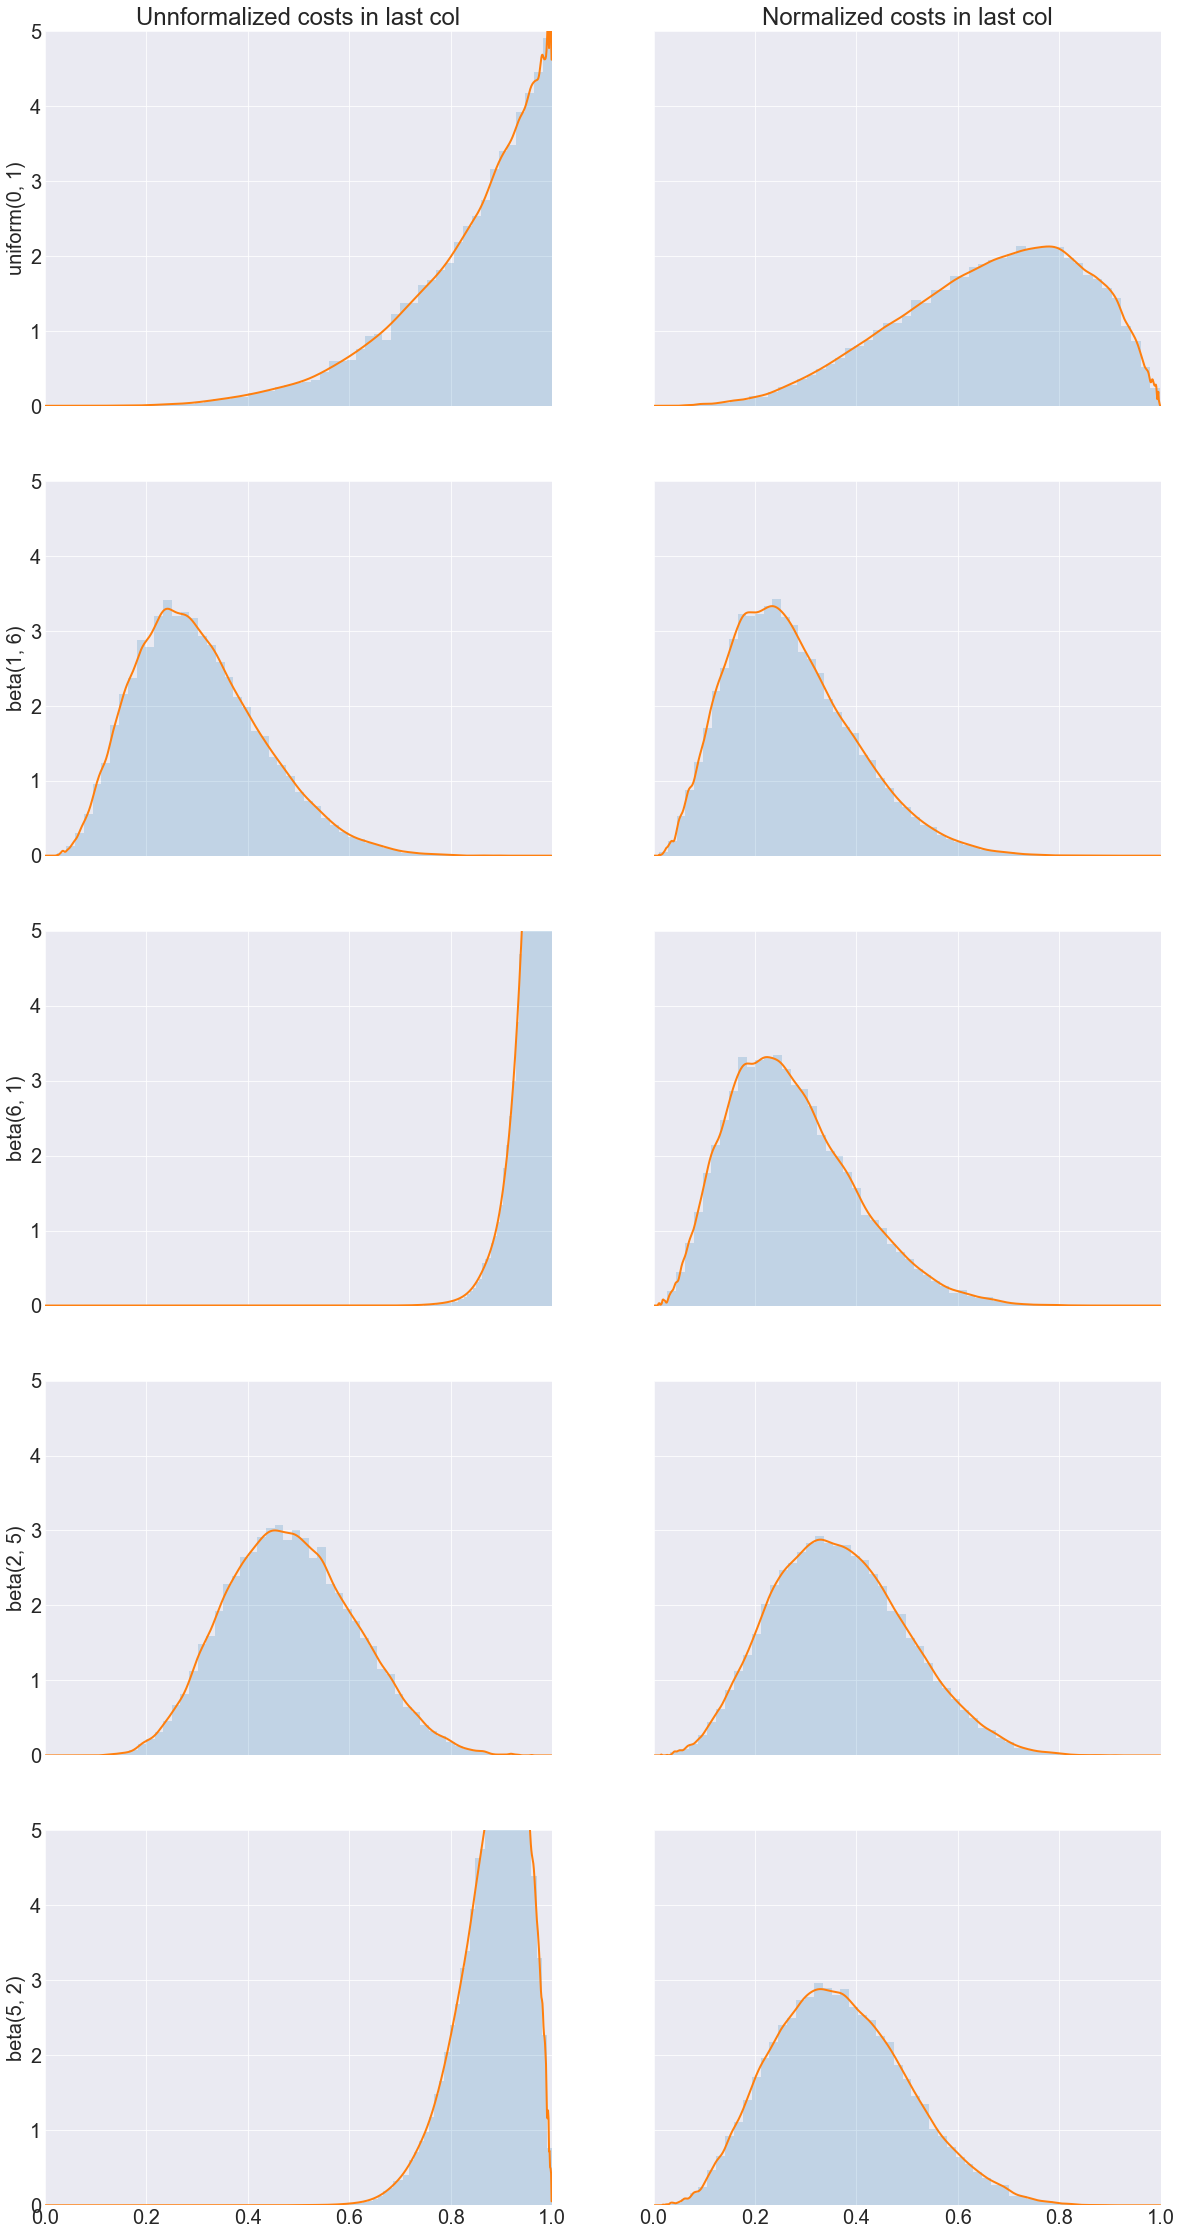

In [17]:
fig, ax = plt.subplots(5, 2, figsize=(20, 8 * 5), sharex=True, sharey=True)

xs = np.linspace(0, 1, 1002)[1: -1].reshape(-1, 1)

for dist_id in range(5):
    print(dist_id)
    
    ax[dist_id][0].hist(cost_pop[dist_id], bins=50, alpha=0.2, density=True)
    ax[dist_id][1].hist(increase_pop[dist_id], bins=50, alpha=0.2, density=True)
    
    kde = kde_utils.KDEHelper(cost_pop[dist_id], cost_bandwidths[dist_id])
    ax[dist_id][0].plot(xs, kde.get_transformed_pdf(xs))
    
    kde = kde_utils.KDEHelper(increase_pop[dist_id], increase_bandwidths[dist_id])
    ax[dist_id][1].plot(xs, kde.get_transformed_pdf(xs))

    ax[dist_id][0].set_ylabel(labels[dist_id])
    ax[dist_id][0].set_ylim(0, 5)
    ax[dist_id][0].set_xlim(0, 1)
    
ax[0][0].set_title('Unnformalized costs in last col')
ax[0][1].set_title('Normalized costs in last col')

plt.show()

5
6
7
8
9


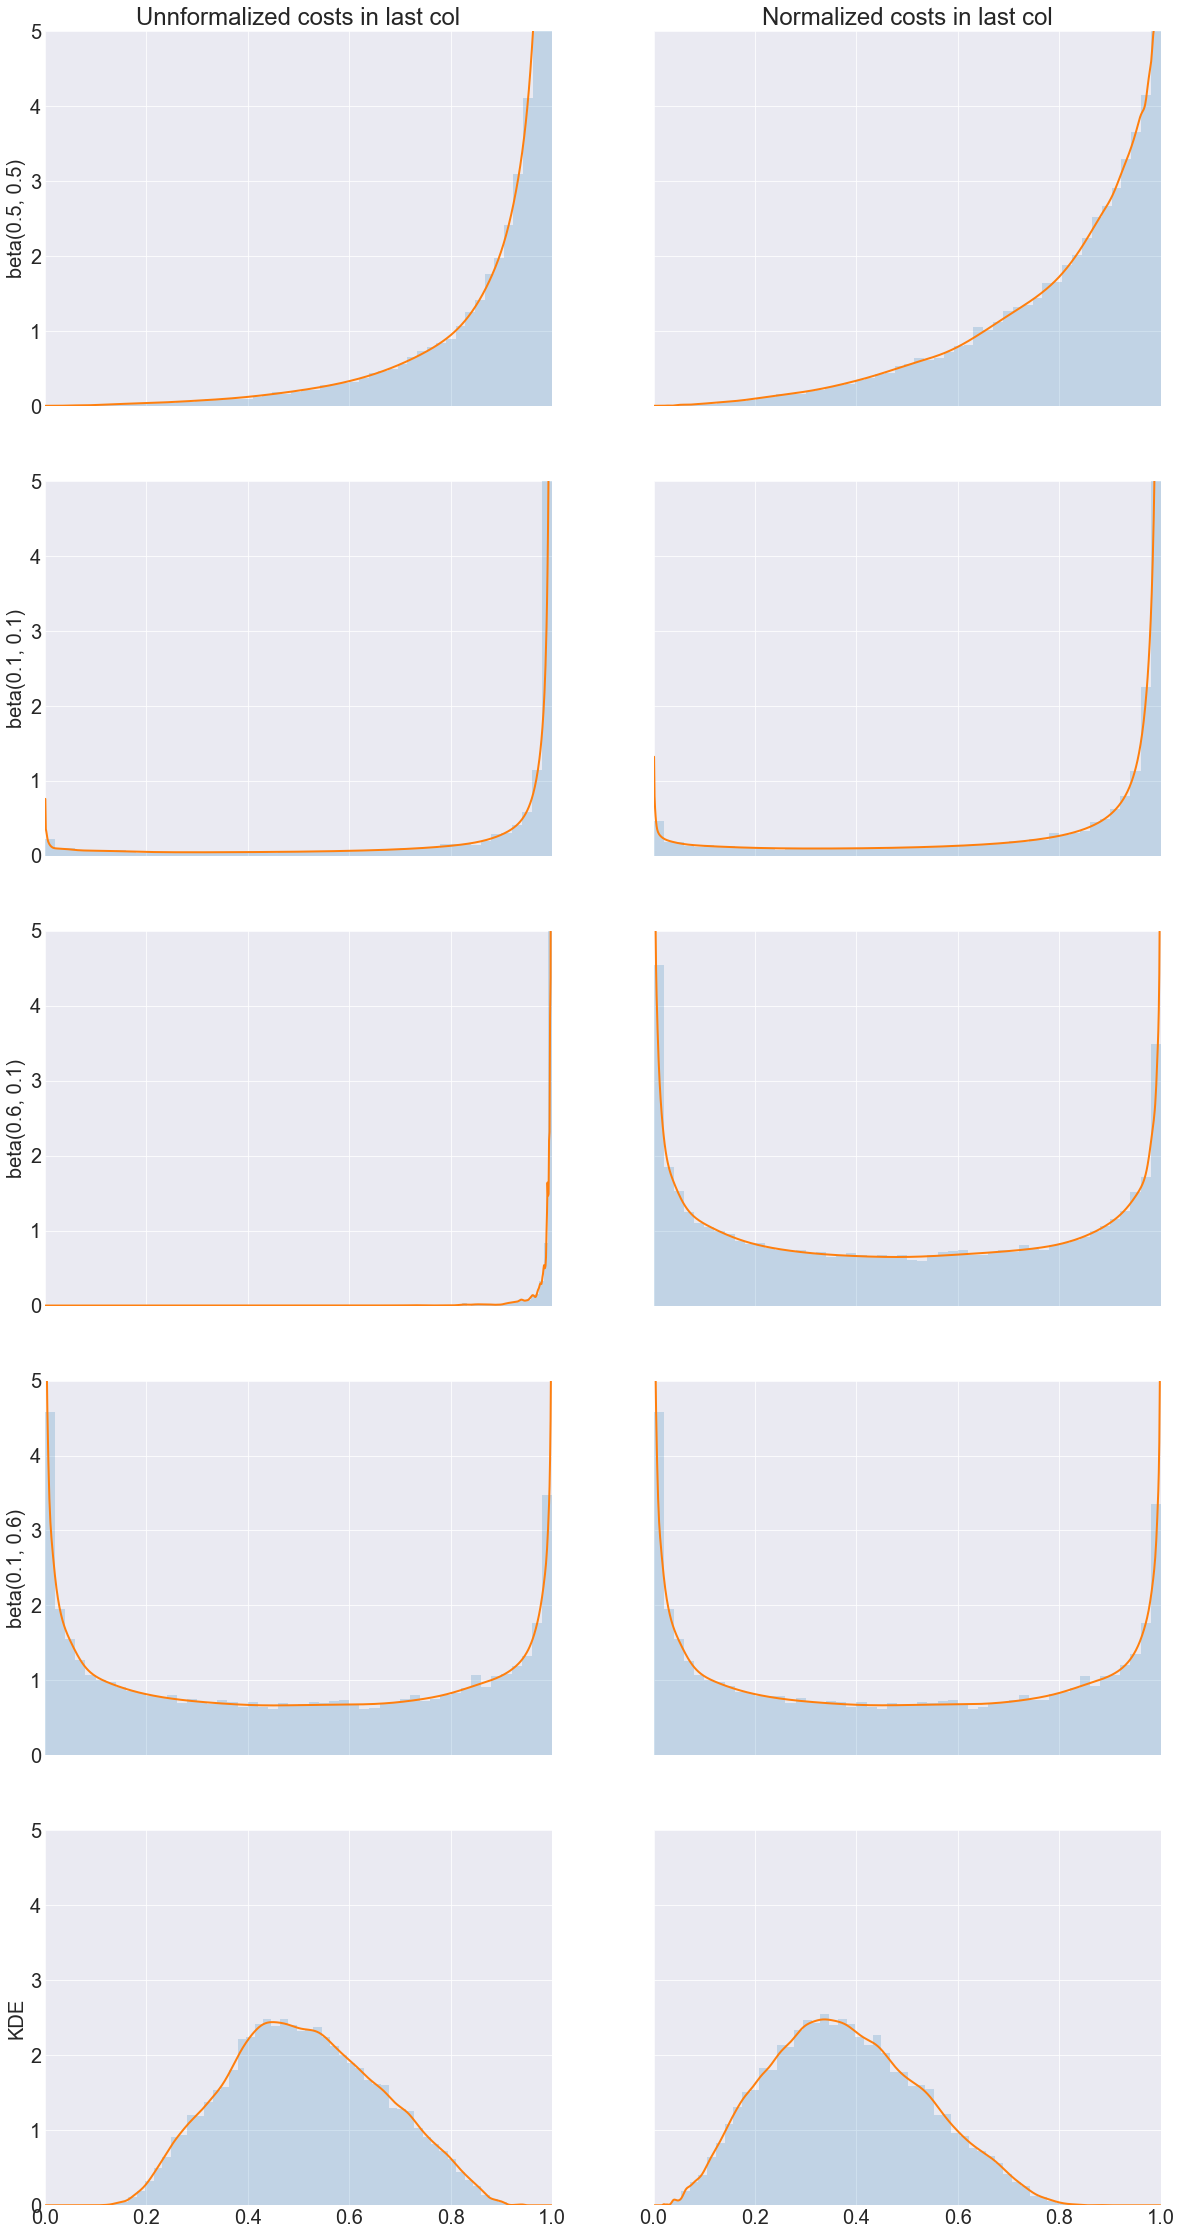

In [18]:
fig, ax = plt.subplots(5, 2, figsize=(20, 8 * 5), sharex=True, sharey=True)

xs = np.linspace(0, 1, 1002)[1: -1].reshape(-1, 1)

for dist_id in range(5, 10):
    print(dist_id)
    
    ax[dist_id - 5][0].hist(cost_pop[dist_id], bins=50, alpha=0.2, density=True)
    ax[dist_id- 5][1].hist(increase_pop[dist_id], bins=50, alpha=0.2, density=True)
    
    kde = kde_utils.KDEHelper(cost_pop[dist_id], cost_bandwidths[dist_id])
    ax[dist_id - 5][0].plot(xs, kde.get_transformed_pdf(xs))
    
    kde = kde_utils.KDEHelper(increase_pop[dist_id], increase_bandwidths[dist_id])
    ax[dist_id - 5][1].plot(xs, kde.get_transformed_pdf(xs))

    ax[dist_id - 5][0].set_ylabel(labels[dist_id])
    ax[dist_id - 5][0].set_ylim(0, 5)
    ax[dist_id - 5][0].set_xlim(0, 1)
    
ax[0][0].set_title('Unnformalized costs in last col')
ax[0][1].set_title('Normalized costs in last col')

plt.show()